Processing TIFF file...


Cannot find header.dxf (GDAL_DATA is not defined)


Success! Created 1 polygons.


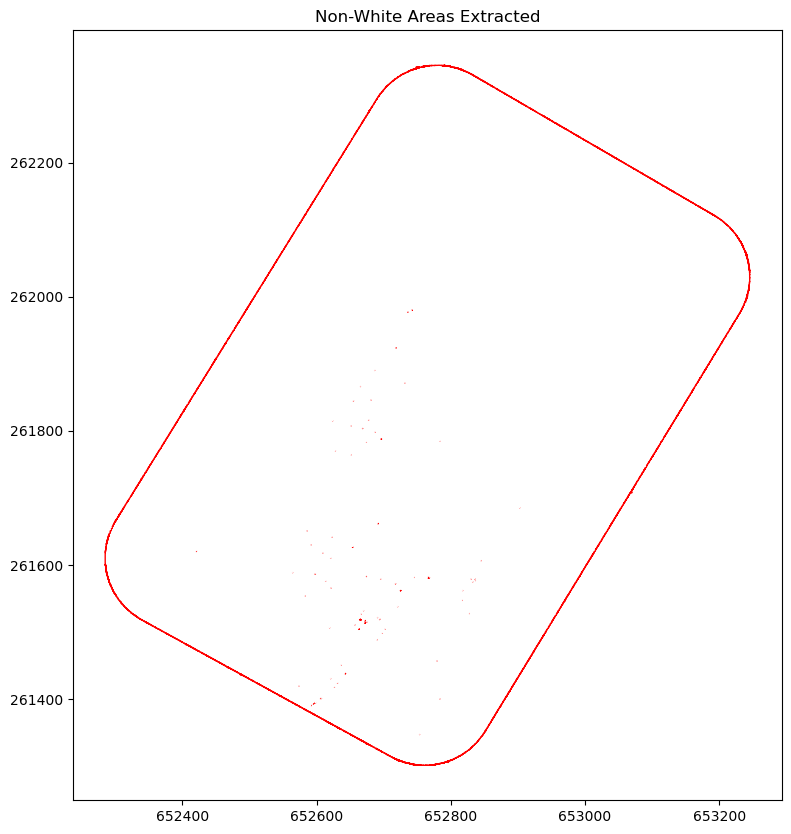

In [3]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt

# Set paths 
input_tif = r"G:/Dokumen Orthophoto/Sumbu Bersatu.tif"
output_gpkg = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/SumbuBersatu.gpkg"

def extract_non_white_areas(tif_path, output_path, white_threshold=250, min_area=100):
    """Digitize only non-white areas from TIFF"""
    
    with rasterio.open(tif_path) as src:
        # Read all bands and create mask
        data = src.read()
        
        # For RGB images, check all bands
        if len(data) == 3:  # RGB image
            # True where pixel is NOT white (any band < threshold)
            mask = np.any(data < white_threshold, axis=0)
        else:  # Single band
            mask = data[0] < white_threshold
        
        # Get transform and CRS
        transform = src.transform
        crs = src.crs
        
        # Calculate minimum area in pixels
        pixel_size = max(abs(transform.a), abs(transform.e))  # in meters
        min_pixels = min_area / (pixel_size ** 2)
        
        # Extract shapes from mask
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for s, v in shapes(mask.astype(np.uint8), transform=transform)
        )
        
        # Create GeoDataFrame and filter
        geoms = []
        for result in results:
            if result['properties']['value'] == 1:  # Only keep non-white areas
                geom = shape(result['geometry'])
                if geom.area >= min_pixels:
                    geoms.append(geom)
        
        if not geoms:
            raise ValueError("No non-white areas found - adjust your threshold")
            
        gdf = gpd.GeoDataFrame({'geometry': geoms}, crs=crs)
        
        # Simplify geometries
        gdf['geometry'] = gdf['geometry'].simplify(pixel_size * 2)
        
        # Save to file
        gdf.to_file(output_path, driver='GPKG')
        return gdf

# Process your file
try:
    print("Processing TIFF file...")
    result = extract_non_white_areas(
        input_tif,
        output_gpkg,
        white_threshold=250,  # Adjust if needed
        min_area=100          # Minimum area in m²
    )
    
    print(f"Success! Created {len(result)} polygons.")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 10))
    result.plot(ax=ax, edgecolor='red', facecolor='none')
    plt.title("Non-White Areas Extracted")
    plt.show()
    
except Exception as e:
    print(f"Error: {str(e)}")

In [23]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

def remove_small_holes(geometry, min_hole_area=20000):
    """
    Remove holes smaller than min_hole_area from a polygon geometry.
    
    Parameters:
    geometry: Shapely Polygon or MultiPolygon
    min_hole_area: Minimum area threshold for holes (default: 1000 square units)
    
    Returns:
    Cleaned geometry with small holes removed
    """
    if geometry is None or geometry.is_empty:
        return geometry
    
    def clean_polygon(poly):
        if not isinstance(poly, Polygon):
            return poly
        
        # Get exterior coordinates
        exterior = poly.exterior
        
        # Filter holes based on area
        large_holes = []
        if poly.interiors:
            for interior in poly.interiors:
                hole_poly = Polygon(interior)
                if hole_poly.area >= min_hole_area:
                    large_holes.append(interior)
        
        # Create new polygon with only large holes
        return Polygon(exterior, large_holes)
    
    if isinstance(geometry, Polygon):
        return clean_polygon(geometry)
    elif isinstance(geometry, MultiPolygon):
        cleaned_polygons = [clean_polygon(poly) for poly in geometry.geoms]
        return MultiPolygon(cleaned_polygons)
    else:
        return geometry

def process_gpkg_holes(input_file, output_file, min_hole_area=20000, layer_name=None):
    """
    Process a GeoPackage file to remove small holes from polygons.
    
    Parameters:
    input_file: Path to input GPKG file
    output_file: Path to output GPKG file
    min_hole_area: Minimum area threshold for holes
    layer_name: Specific layer name (if None, uses first layer)
    """
    try:
        # Read the GeoPackage
        print(f"Reading {input_file}...")
        if layer_name:
            gdf = gpd.read_file(input_file, layer=layer_name)
        else:
            gdf = gpd.read_file(input_file)
        
        print(f"Loaded {len(gdf)} features")
        print(f"CRS: {gdf.crs}")
        
        # Count holes before processing
        total_holes_before = 0
        for geom in gdf.geometry:
            if isinstance(geom, Polygon) and geom.interiors:
                total_holes_before += len(geom.interiors)
            elif isinstance(geom, MultiPolygon):
                for poly in geom.geoms:
                    if isinstance(poly, Polygon) and poly.interiors:
                        total_holes_before += len(poly.interiors)
        
        print(f"Total holes before processing: {total_holes_before}")
        
        # Apply hole removal
        print(f"Removing holes smaller than {min_hole_area} square units...")
        gdf['geometry'] = gdf['geometry'].apply(
            lambda geom: remove_small_holes(geom, min_hole_area)
        )
        
        # Count holes after processing
        total_holes_after = 0
        for geom in gdf.geometry:
            if isinstance(geom, Polygon) and geom.interiors:
                total_holes_after += len(geom.interiors)
            elif isinstance(geom, MultiPolygon):
                for poly in geom.geoms:
                    if isinstance(poly, Polygon) and poly.interiors:
                        total_holes_after += len(poly.interiors)
        
        print(f"Total holes after processing: {total_holes_after}")
        print(f"Removed {total_holes_before - total_holes_after} small holes")
        
        # Save to output file
        print(f"Saving to {output_file}...")
        gdf.to_file(output_file, driver="GPKG")
        print("Processing complete!")
        
        return gdf
        
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def analyze_holes(input_file, layer_name=None):
    """
    Analyze hole sizes in the polygon to help determine appropriate threshold.
    
    Parameters:
    input_file: Path to input GPKG file
    layer_name: Specific layer name (if None, uses first layer)
    """
    try:
        # Read the GeoPackage
        if layer_name:
            gdf = gpd.read_file(input_file, layer=layer_name)
        else:
            gdf = gpd.read_file(input_file)
        
        hole_areas = []
        
        for geom in gdf.geometry:
            if isinstance(geom, Polygon) and geom.interiors:
                for interior in geom.interiors:
                    hole_poly = Polygon(interior)
                    hole_areas.append(hole_poly.area)
            elif isinstance(geom, MultiPolygon):
                for poly in geom.geoms:
                    if isinstance(poly, Polygon) and poly.interiors:
                        for interior in poly.interiors:
                            hole_poly = Polygon(interior)
                            hole_areas.append(hole_poly.area)
        
        if hole_areas:
            hole_areas = np.array(hole_areas)
            print(f"\nHole Analysis:")
            print(f"Total holes found: {len(hole_areas)}")
            print(f"Smallest hole area: {hole_areas.min():.2f}")
            print(f"Largest hole area: {hole_areas.max():.2f}")
            print(f"Mean hole area: {hole_areas.mean():.2f}")
            print(f"Median hole area: {np.median(hole_areas):.2f}")
            print(f"75th percentile: {np.percentile(hole_areas, 75):.2f}")
            print(f"90th percentile: {np.percentile(hole_areas, 90):.2f}")
        else:
            print("No holes found in the polygons.")
        
        return hole_areas
        
    except Exception as e:
        print(f"Error analyzing holes: {e}")
        return None

# Example usage
if __name__ == "__main__":
    # Set your file paths
    input_gpkg = "G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/pedulipesisir.gpkg"
    output_gpkg = "G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/pedulipesisir_no_small_holes.gpkg" 
    
    # First, analyze the holes to understand their size distribution
    print("Analyzing hole sizes...")
    hole_areas = analyze_holes(input_gpkg)
    
    if hole_areas is not None and len(hole_areas) > 0:
        # Suggest threshold based on analysis
        suggested_threshold = np.percentile(hole_areas, 90)  # Remove smallest 90% of holes
        print(f"\nSuggested threshold (90th percentile): {suggested_threshold:.2f}")
        
        # Process with suggested threshold
        min_area_threshold = suggested_threshold
    else:
        # Default threshold if no holes found or analysis failed
        min_area_threshold = 20000
    
    # Process the file
    result_gdf = process_gpkg_holes(
        input_file=input_gpkg,
        output_file=output_gpkg,
        min_hole_area=min_area_threshold
    )
    
    # Optional: You can also specify a custom threshold
    # result_gdf = process_gpkg_holes(
    #     input_file=input_gpkg,
    #     output_file=output_gpkg,
    #     min_hole_area=5000  # Custom threshold
    # )

Analyzing hole sizes...

Hole Analysis:
Total holes found: 28116
Smallest hole area: 0.00
Largest hole area: 13.65
Mean hole area: 0.01
Median hole area: 0.00
75th percentile: 0.01
90th percentile: 0.01

Suggested threshold (90th percentile): 0.01
Reading G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/pedulipesisir.gpkg...
Loaded 1 features
CRS: EPSG:32647
Total holes before processing: 28116
Removing holes smaller than 0.007800858153535132 square units...
Total holes after processing: 2851
Removed 25265 small holes
Saving to G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/pedulipesisir_no_small_holes.gpkg...
Processing complete!


In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
import logging
import argparse
from pathlib import Path
from dataclasses import dataclass
from typing import Optional
import os

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class ProcessingConfig:
    """Configuration class for processing parameters"""
    white_threshold: int = int(os.getenv('WHITE_THRESHOLD', 250))
    min_area: float = float(os.getenv('MIN_AREA', 100))
    max_area: Optional[float] = None if not os.getenv('MAX_AREA') else float(os.getenv('MAX_AREA'))
    simplify_tolerance: float = float(os.getenv('SIMPLIFY_TOL', 2.0))
    connectivity: int = int(os.getenv('CONNECTIVITY', 8))

def validate_inputs(tif_path: str, output_path: str, config: ProcessingConfig) -> None:
    """Validate input parameters"""
    if not Path(tif_path).exists():
        raise FileNotFoundError(f"Input file not found: {tif_path}")
    
    if not 0 <= config.white_threshold <= 255:
        raise ValueError("white_threshold must be between 0 and 255")
    
    if config.min_area <= 0:
        raise ValueError("min_area must be positive")
    
    if config.max_area and config.max_area <= config.min_area:
        raise ValueError("max_area must be greater than min_area")
    
    # Create output directory if it doesn't exist
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)

def extract_non_white_areas(tif_path: str, output_path: str, config: ProcessingConfig) -> gpd.GeoDataFrame:
    """
    Digitize only non-white areas from TIFF
    
    Args:
        tif_path: Path to input TIFF file
        output_path: Path for output GeoPackage
        config: Processing configuration
    
    Returns:
        GeoDataFrame with extracted polygons
    """
    logger.info(f"Processing TIFF file: {tif_path}")
    logger.info(f"Configuration: threshold={config.white_threshold}, min_area={config.min_area}m²")
    
    # Validate inputs
    validate_inputs(tif_path, output_path, config)
    
    with rasterio.open(tif_path) as src:
        logger.info(f"Image dimensions: {src.width}x{src.height}, bands: {src.count}")
        logger.info(f"CRS: {src.crs}, pixel size: ~{abs(src.transform.a):.2f}m")
        
        # Read all bands and create mask
        data = src.read()
        
        # Handle different image types
        if src.count == 4:  # RGBA
            # Use RGB channels, ignore alpha
            mask = np.any(data[:3] < config.white_threshold, axis=0)
            logger.info("Processing RGBA image (ignoring alpha channel)")
        elif src.count == 3:  # RGB
            mask = np.any(data < config.white_threshold, axis=0)
            logger.info("Processing RGB image")
        elif src.count == 1:  # Grayscale
            mask = data[0] < config.white_threshold
            logger.info("Processing grayscale image")
        else:
            logger.warning(f"Unusual number of bands ({src.count}), using first 3")
            mask = np.any(data[:3] < config.white_threshold, axis=0)
        
        # Handle NoData values
        if src.nodata is not None:
            nodata_mask = np.any(data == src.nodata, axis=0)
            mask = mask & ~nodata_mask
            logger.info(f"Excluding NoData pixels (value: {src.nodata})")
        
        # Calculate pixel area for filtering
        pixel_size = max(abs(src.transform.a), abs(src.transform.e))
        pixel_area = pixel_size ** 2
        min_pixels = config.min_area / pixel_area
        max_pixels = config.max_area / pixel_area if config.max_area else None
        
        logger.info(f"Pixel size: {pixel_size:.2f}m, pixel area: {pixel_area:.2f}m²")
        logger.info(f"Min pixels threshold: {min_pixels:.0f}")
        if max_pixels:
            logger.info(f"Max pixels threshold: {max_pixels:.0f}")
        
        # Extract shapes from mask
        logger.info("Extracting polygons from mask...")
        results = list(shapes(
            mask.astype(np.uint8), 
            transform=src.transform,
            connectivity=config.connectivity,
            mask=mask
        ))
        
        # Create geometries and filter by area
        geoms = []
        total_polygons = 0
        
        for geom_shape, value in results:
            if value == 1:  # Only keep non-white areas (True pixels)
                total_polygons += 1
                geom = shape(geom_shape)
                
                # Area filtering
                if geom.area >= min_pixels:
                    if max_pixels is None or geom.area <= max_pixels:
                        geoms.append(geom)
        
        logger.info(f"Found {total_polygons} total polygons")
        logger.info(f"Kept {len(geoms)} polygons after area filtering")
        
        if not geoms:
            raise ValueError(
                f"No polygons found meeting criteria. "
                f"Try adjusting white_threshold ({config.white_threshold}) or min_area ({config.min_area}m²)"
            )
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({'geometry': geoms}, crs=src.crs)
        
        # Add area column (in square meters)
        gdf['area_m2'] = gdf.geometry.area * (pixel_area)
        
        # Simplify geometries if tolerance > 0
        if config.simplify_tolerance > 0:
            logger.info(f"Simplifying geometries with tolerance: {config.simplify_tolerance}")
            original_vertices = sum(len(geom.exterior.coords) for geom in gdf.geometry if hasattr(geom, 'exterior'))
            gdf['geometry'] = gdf['geometry'].simplify(pixel_size * config.simplify_tolerance)
            new_vertices = sum(len(geom.exterior.coords) for geom in gdf.geometry if hasattr(geom, 'exterior'))
            logger.info(f"Reduced vertices from {original_vertices} to {new_vertices}")
        
        # Save to file
        logger.info(f"Saving to: {output_path}")
        gdf.to_file(output_path, driver='ESRI Shapefile')
        
        # Log summary statistics
        total_area = gdf['area_m2'].sum()
        logger.info(f"Total area: {total_area:.2f}m² ({total_area/10000:.2f} hectares)")
        logger.info(f"Average polygon area: {gdf['area_m2'].mean():.2f}m²")
        logger.info(f"Largest polygon: {gdf['area_m2'].max():.2f}m²")
        
        return gdf

def create_visualization(gdf: gpd.GeoDataFrame, title: str = "Non-White Areas Extracted") -> None:
    """Create and display visualization of results"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot with color based on area
    gdf.plot(
        ax=ax, 
        column='area_m2',
        cmap='viridis',
        edgecolor='red',
        alpha=0.7,
        legend=True,
        legend_kwds={'label': 'Area (m²)'}
    )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.tight_layout()
    plt.show()

def main():
    """Main function with command line interface"""
    parser = argparse.ArgumentParser(description='Extract non-white areas from orthophoto TIFF files to Shapefile')
    parser.add_argument('--input', '-i', required=True, help='Input TIFF file path')
    parser.add_argument('--output', '-o', required=True, help='Output Shapefile (.shp) path')
    parser.add_argument('--threshold', '-t', type=int, default=250, help='White threshold (0-255)')
    parser.add_argument('--min-area', '-m', type=float, default=100, help='Minimum area in m²')
    parser.add_argument('--max-area', type=float, help='Maximum area in m²')
    parser.add_argument('--simplify', '-s', type=float, default=2.0, help='Simplification tolerance')
    parser.add_argument('--no-plot', action='store_true', help='Skip visualization')
    
    args = parser.parse_args()
    
    # Create configuration
    config = ProcessingConfig(
        white_threshold=args.threshold,
        min_area=args.min_area,
        max_area=args.max_area,
        simplify_tolerance=args.simplify,
    )
    
    try:
        # Process the file
        result = extract_non_white_areas(args.input, args.output, config)
        
        logger.info("✅ Processing completed successfully!")
        logger.info(f"Created {len(result)} polygons in {args.output}")
        
        # Visualize results
        if not args.no_plot:
            create_visualization(result)
        
    except Exception as e:
        logger.error(f"❌ Error: {str(e)}")
        raise

if __name__ == "__main__":
    # Example usage if run directly (comment out main() to use this)
    # main()
    
    # Your original hardcoded approach (updated with configuration):
    input_tif = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/karyabersama.tif"
    output_shp = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/karyabersama.shp"
    
    # Create custom configuration
    config = ProcessingConfig(
        white_threshold=250,    # Adjust if needed
        min_area=100,          # Minimum area in m²
        max_area=None,         # No maximum limit
        simplify_tolerance=2.0, # Simplification factor
        connectivity=8         # 8-connectivity for smoother polygons
    )
    
    try:
        print("🗺️  Processing TIFF file...")
        result = extract_non_white_areas(input_tif, output_shp, config)
        
        print(f"✅ Success! Created {len(result)} polygons.")
        print(f"📊 Total area: {result['area_m2'].sum():.2f}m² ({result['area_m2'].sum()/10000:.2f} hectares)")
        
        # Enhanced visualization
        create_visualization(result, "Sumbu Bersatu - Non-White Areas")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        logger.exception("Detailed error information:")

2025-06-27 14:16:22,029 - INFO - Eliminating white areas from: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/ecw1.tif
2025-06-27 14:16:22,035 - INFO - Output TIFF will be saved to: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alampesisir.tif
2025-06-27 14:16:22,146 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)


🗺️  Processing TIFF file...
📸 Eliminating white areas and creating clean TIFF...


2025-06-27 14:16:22,296 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:16:22,303 - INFO - Image dimensions: 22568x30336, bands: 4
2025-06-27 14:16:22,305 - INFO - CRS: EPSG:32647, pixel size: ~0.05m
2025-06-27 14:17:12,662 - INFO - Processing RGBA image (checking RGB channels for white areas)
2025-06-27 14:17:28,244 - INFO - Preserving NoData pixels (value: 256.0)
2025-06-27 14:17:29,260 - INFO - Found 389,876,376 white pixels (56.95% of image)
2025-06-27 14:17:51,199 - INFO - Replacing white areas with value: 0
2025-06-27 14:17:51,215 - INFO - Writing processed TIFF...
2025-06-27 14:17:52,394 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:19:12,222 - INFO - ✅ Processed TIFF saved to: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alampesisir.tif
2025-06-27 14:19:13,921 - INFO - Processing TIFF file: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/ecw1.tif
2025-06-27 14:19:13,921 - 

🔍 Extracting non-white area polygons...


2025-06-27 14:19:34,083 - INFO - Processing RGBA image (ignoring alpha channel)
2025-06-27 14:19:39,828 - INFO - Excluding NoData pixels (value: 256.0)
2025-06-27 14:19:39,828 - INFO - Pixel size: 0.05m, pixel area: 0.00m²
2025-06-27 14:19:39,833 - INFO - Min pixels threshold: 38457
2025-06-27 14:19:39,834 - INFO - Extracting polygons from mask...
2025-06-27 14:20:10,938 - INFO - Found 13918 total polygons
2025-06-27 14:20:10,938 - INFO - Kept 1 polygons after area filtering
2025-06-27 14:20:10,994 - INFO - Simplifying geometries with tolerance: 2.0
2025-06-27 14:20:13,050 - INFO - Reduced vertices from 156787 to 29788
2025-06-27 14:20:13,050 - INFO - Saving to: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alaampesisir.shp
2025-06-27 14:20:13,310 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:20:13,336 - WARNING - Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:20:13,378 - WARNING - Cannot find header.dxf (GDAL_DATA

✅ Success! Created 1 polygons.
📊 Total area: 1992.05m² (0.20 hectares)
💾 Clean TIFF saved to: G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alampesisir.tif


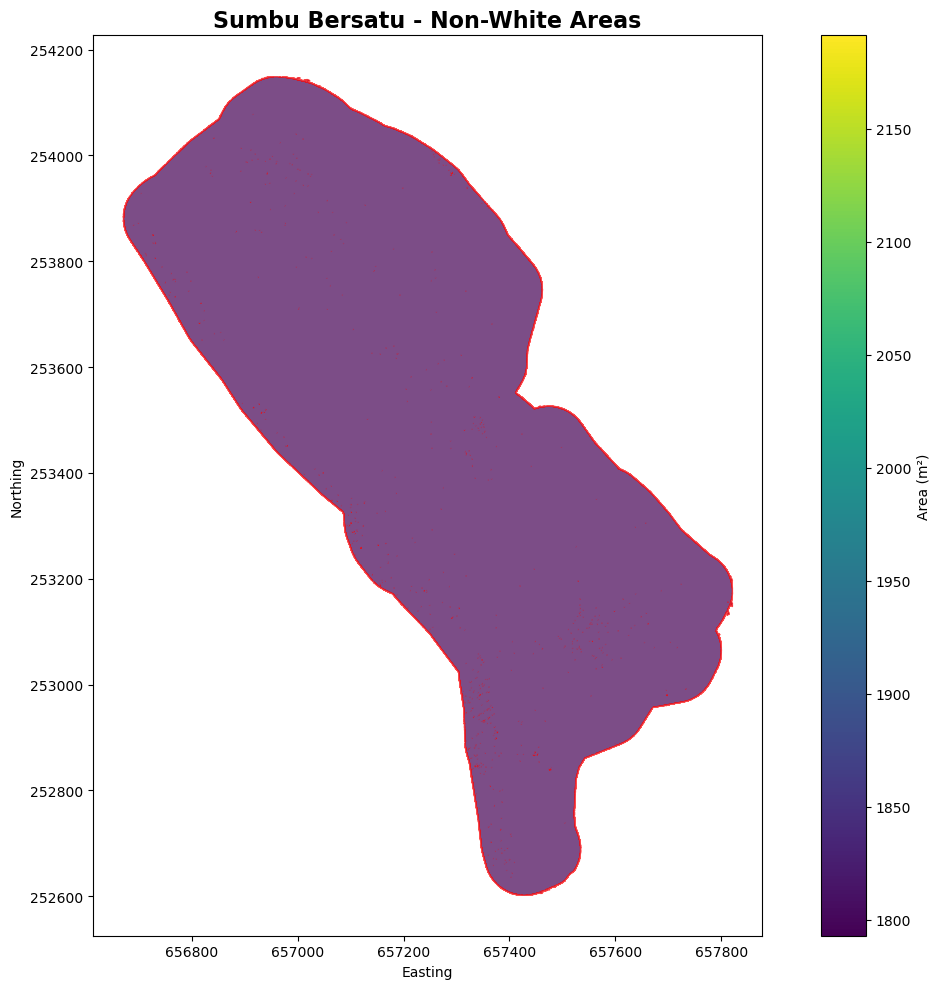

2025-06-27 14:20:19,208 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:20:19,304 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:20:19,343 - WARNING - CPLE_AppDefined in G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/ecw1.tif.ovr: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2025-06-27 14:20:19,344 - WARNING - CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2025-06-27 14:20:19,348 - WARNING - CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2025-06-27 14:20:19,350 - WARNING - CPLE_AppDefined in TIFFReadDirectory:Sum of Photometr

🖼️ Creating before/after comparison...


2025-06-27 14:20:19,597 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)
2025-06-27 14:20:19,624 - WARNING - CPLE_FileIO in Cannot find header.dxf (GDAL_DATA is not defined)


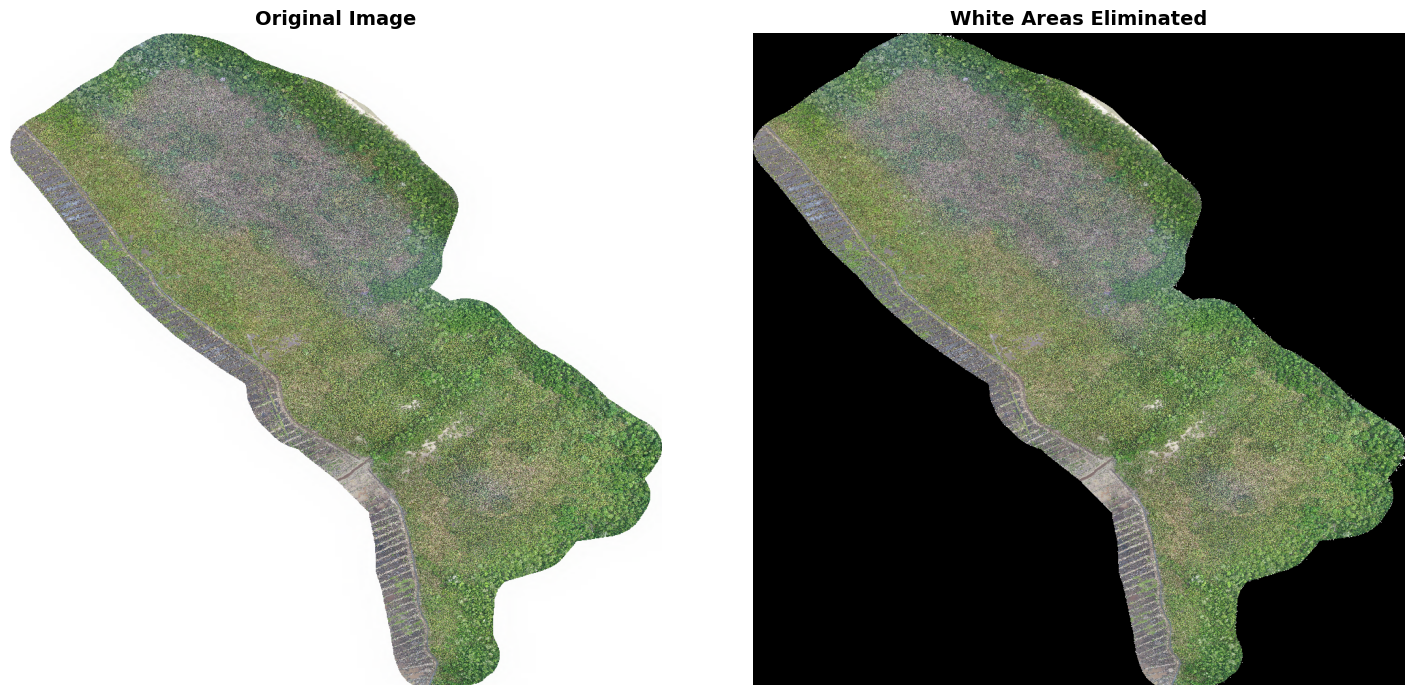

In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
import logging
import argparse
from pathlib import Path
from dataclasses import dataclass
from typing import Optional
import os

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class ProcessingConfig:
    """Configuration class for processing parameters"""
    white_threshold: int = int(os.getenv('WHITE_THRESHOLD', 250))
    min_area: float = float(os.getenv('MIN_AREA', 100))
    max_area: Optional[float] = None if not os.getenv('MAX_AREA') else float(os.getenv('MAX_AREA'))
    simplify_tolerance: float = float(os.getenv('SIMPLIFY_TOL', 2.0))
    connectivity: int = int(os.getenv('CONNECTIVITY', 8))
    replacement_value: int = int(os.getenv('REPLACEMENT_VALUE', 0))  # Value to replace white areas with

def validate_inputs(tif_path: str, output_path: str, config: ProcessingConfig) -> None:
    """Validate input parameters"""
    if not Path(tif_path).exists():
        raise FileNotFoundError(f"Input file not found: {tif_path}")
    
    if not 0 <= config.white_threshold <= 255:
        raise ValueError("white_threshold must be between 0 and 255")
    
    if config.min_area <= 0:
        raise ValueError("min_area must be positive")
    
    if config.max_area and config.max_area <= config.min_area:
        raise ValueError("max_area must be greater than min_area")
    
    # Create output directory if it doesn't exist
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)

def eliminate_white_areas_and_export_tif(tif_path: str, output_tif_path: str, config: ProcessingConfig) -> np.ndarray:
    """
    Eliminate white areas from TIFF and export new TIFF without white areas
    
    Args:
        tif_path: Path to input TIFF file
        output_tif_path: Path for output TIFF file
        config: Processing configuration
    
    Returns:
        Processed image array
    """
    logger.info(f"Eliminating white areas from: {tif_path}")
    logger.info(f"Output TIFF will be saved to: {output_tif_path}")
    
    with rasterio.open(tif_path) as src:
        logger.info(f"Image dimensions: {src.width}x{src.height}, bands: {src.count}")
        logger.info(f"CRS: {src.crs}, pixel size: ~{abs(src.transform.a):.2f}m")
        
        # Read all bands
        data = src.read()
        
        # Create a copy of the data to modify
        processed_data = data.copy()
        
        # Create white area mask based on image type
        if src.count == 4:  # RGBA
            # Check if all RGB channels are above threshold (ignoring alpha)
            white_mask = np.all(data[:3] >= config.white_threshold, axis=0)
            logger.info("Processing RGBA image (checking RGB channels for white areas)")
        elif src.count == 3:  # RGB
            white_mask = np.all(data >= config.white_threshold, axis=0)
            logger.info("Processing RGB image")
        elif src.count == 1:  # Grayscale
            white_mask = data[0] >= config.white_threshold
            logger.info("Processing grayscale image")
        else:
            logger.warning(f"Unusual number of bands ({src.count}), using first 3")
            white_mask = np.all(data[:3] >= config.white_threshold, axis=0)
        
        # Handle NoData values
        if src.nodata is not None:
            nodata_mask = np.any(data == src.nodata, axis=0)
            white_mask = white_mask & ~nodata_mask
            logger.info(f"Preserving NoData pixels (value: {src.nodata})")
        
        # Count white pixels
        white_pixel_count = np.sum(white_mask)
        total_pixels = white_mask.size
        white_percentage = (white_pixel_count / total_pixels) * 100
        
        logger.info(f"Found {white_pixel_count:,} white pixels ({white_percentage:.2f}% of image)")
        
        # Replace white areas with specified value
        if src.count == 1:  # Grayscale
            processed_data[0][white_mask] = config.replacement_value
        else:  # Multi-band
            for band in range(src.count):
                processed_data[band][white_mask] = config.replacement_value
        
        logger.info(f"Replacing white areas with value: {config.replacement_value}")
        
        # Update metadata for output file
        out_meta = src.meta.copy()
        out_meta.update({
            "compress": "lzw",  # Add compression to reduce file size
            "tiled": True,      # Enable tiling for better performance
            "blockxsize": 512,
            "blockysize": 512
        })
        
        # Write the processed data to new TIFF
        logger.info("Writing processed TIFF...")
        with rasterio.open(output_tif_path, 'w', **out_meta) as dst:
            dst.write(processed_data)
            
            # Copy any existing color interpretation
            if hasattr(src, 'colorinterp'):
                dst.colorinterp = src.colorinterp
        
        logger.info(f"✅ Processed TIFF saved to: {output_tif_path}")
        
        return processed_data

def extract_non_white_areas(tif_path: str, output_path: str, config: ProcessingConfig) -> gpd.GeoDataFrame:
    """
    Digitize only non-white areas from TIFF (original function with minor updates)
    """
    logger.info(f"Processing TIFF file: {tif_path}")
    logger.info(f"Configuration: threshold={config.white_threshold}, min_area={config.min_area}m²")
    
    # Validate inputs
    validate_inputs(tif_path, output_path, config)
    
    with rasterio.open(tif_path) as src:
        logger.info(f"Image dimensions: {src.width}x{src.height}, bands: {src.count}")
        logger.info(f"CRS: {src.crs}, pixel size: ~{abs(src.transform.a):.2f}m")
        
        # Read all bands and create mask
        data = src.read()
        
        # Handle different image types
        if src.count == 4:  # RGBA
            # Use RGB channels, ignore alpha
            mask = np.any(data[:3] < config.white_threshold, axis=0)
            logger.info("Processing RGBA image (ignoring alpha channel)")
        elif src.count == 3:  # RGB
            mask = np.any(data < config.white_threshold, axis=0)
            logger.info("Processing RGB image")
        elif src.count == 1:  # Grayscale
            mask = data[0] < config.white_threshold
            logger.info("Processing grayscale image")
        else:
            logger.warning(f"Unusual number of bands ({src.count}), using first 3")
            mask = np.any(data[:3] < config.white_threshold, axis=0)
        
        # Handle NoData values
        if src.nodata is not None:
            nodata_mask = np.any(data == src.nodata, axis=0)
            mask = mask & ~nodata_mask
            logger.info(f"Excluding NoData pixels (value: {src.nodata})")
        
        # Calculate pixel area for filtering
        pixel_size = max(abs(src.transform.a), abs(src.transform.e))
        pixel_area = pixel_size ** 2
        min_pixels = config.min_area / pixel_area
        max_pixels = config.max_area / pixel_area if config.max_area else None
        
        logger.info(f"Pixel size: {pixel_size:.2f}m, pixel area: {pixel_area:.2f}m²")
        logger.info(f"Min pixels threshold: {min_pixels:.0f}")
        if max_pixels:
            logger.info(f"Max pixels threshold: {max_pixels:.0f}")
        
        # Extract shapes from mask
        logger.info("Extracting polygons from mask...")
        results = list(shapes(
            mask.astype(np.uint8), 
            transform=src.transform,
            connectivity=config.connectivity,
            mask=mask
        ))
        
        # Create geometries and filter by area
        geoms = []
        total_polygons = 0
        
        for geom_shape, value in results:
            if value == 1:  # Only keep non-white areas (True pixels)
                total_polygons += 1
                geom = shape(geom_shape)
                
                # Area filtering
                if geom.area >= min_pixels:
                    if max_pixels is None or geom.area <= max_pixels:
                        geoms.append(geom)
        
        logger.info(f"Found {total_polygons} total polygons")
        logger.info(f"Kept {len(geoms)} polygons after area filtering")
        
        if not geoms:
            raise ValueError(
                f"No polygons found meeting criteria. "
                f"Try adjusting white_threshold ({config.white_threshold}) or min_area ({config.min_area}m²)"
            )
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({'geometry': geoms}, crs=src.crs)
        
        # Add area column (in square meters)
        gdf['area_m2'] = gdf.geometry.area * (pixel_area)
        
        # Simplify geometries if tolerance > 0
        if config.simplify_tolerance > 0:
            logger.info(f"Simplifying geometries with tolerance: {config.simplify_tolerance}")
            original_vertices = sum(len(geom.exterior.coords) for geom in gdf.geometry if hasattr(geom, 'exterior'))
            gdf['geometry'] = gdf['geometry'].simplify(pixel_size * config.simplify_tolerance)
            new_vertices = sum(len(geom.exterior.coords) for geom in gdf.geometry if hasattr(geom, 'exterior'))
            logger.info(f"Reduced vertices from {original_vertices} to {new_vertices}")
        
        # Save to file
        logger.info(f"Saving to: {output_path}")
        gdf.to_file(output_path, driver='ESRI Shapefile')
        
        # Log summary statistics
        total_area = gdf['area_m2'].sum()
        logger.info(f"Total area: {total_area:.2f}m² ({total_area/10000:.2f} hectares)")
        logger.info(f"Average polygon area: {gdf['area_m2'].mean():.2f}m²")
        logger.info(f"Largest polygon: {gdf['area_m2'].max():.2f}m²")
        
        return gdf

def create_visualization(gdf: gpd.GeoDataFrame, title: str = "Non-White Areas Extracted") -> None:
    """Create and display visualization of results"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot with color based on area
    gdf.plot(
        ax=ax, 
        column='area_m2',
        cmap='viridis',
        edgecolor='red',
        alpha=0.7,
        legend=True,
        legend_kwds={'label': 'Area (m²)'}
    )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.tight_layout()
    plt.show()

def create_before_after_comparison(original_tif: str, processed_tif: str, sample_size: int = 1000):
    """Create a before/after comparison visualization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Read and display original
    with rasterio.open(original_tif) as src:
        # Read a sample for visualization (to handle large files)
        if src.width > sample_size or src.height > sample_size:
            # Calculate decimation factor
            dec_factor = max(src.width // sample_size, src.height // sample_size, 1)
            original_data = src.read(window=rasterio.windows.Window(0, 0, 
                                                                   min(src.width, sample_size * dec_factor), 
                                                                   min(src.height, sample_size * dec_factor)),
                                   out_shape=(src.count, sample_size, sample_size))
        else:
            original_data = src.read()
        
        if src.count >= 3:
            # RGB display
            rgb_original = np.transpose(original_data[:3], (1, 2, 0))
            ax1.imshow(rgb_original)
        else:
            # Grayscale display
            ax1.imshow(original_data[0], cmap='gray')
        
        ax1.set_title('Original Image', fontsize=14, fontweight='bold')
        ax1.axis('off')
    
    # Read and display processed
    with rasterio.open(processed_tif) as src:
        if src.width > sample_size or src.height > sample_size:
            dec_factor = max(src.width // sample_size, src.height // sample_size, 1)
            processed_data = src.read(window=rasterio.windows.Window(0, 0, 
                                                                    min(src.width, sample_size * dec_factor), 
                                                                    min(src.height, sample_size * dec_factor)),
                                     out_shape=(src.count, sample_size, sample_size))
        else:
            processed_data = src.read()
        
        if src.count >= 3:
            # RGB display
            rgb_processed = np.transpose(processed_data[:3], (1, 2, 0))
            ax2.imshow(rgb_processed)
        else:
            # Grayscale display
            ax2.imshow(processed_data[0], cmap='gray')
        
        ax2.set_title('White Areas Eliminated', fontsize=14, fontweight='bold')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function with command line interface"""
    parser = argparse.ArgumentParser(description='Process orthophoto TIFF files: eliminate white areas and/or extract polygons')
    parser.add_argument('--input', '-i', required=True, help='Input TIFF file path')
    parser.add_argument('--output-tif', help='Output TIFF file path (for white area elimination)')
    parser.add_argument('--output-shp', help='Output Shapefile (.shp) path (for polygon extraction)')
    parser.add_argument('--threshold', '-t', type=int, default=250, help='White threshold (0-255)')
    parser.add_argument('--min-area', '-m', type=float, default=100, help='Minimum area in m²')
    parser.add_argument('--max-area', type=float, help='Maximum area in m²')
    parser.add_argument('--simplify', '-s', type=float, default=2.0, help='Simplification tolerance')
    parser.add_argument('--replacement-value', '-r', type=int, default=0, help='Value to replace white areas with (0-255)')
    parser.add_argument('--no-plot', action='store_true', help='Skip visualization')
    parser.add_argument('--no-comparison', action='store_true', help='Skip before/after comparison')
    
    args = parser.parse_args()
    
    if not args.output_tif and not args.output_shp:
        parser.error("At least one output format must be specified (--output-tif or --output-shp)")
    
    # Create configuration
    config = ProcessingConfig(
        white_threshold=args.threshold,
        min_area=args.min_area,
        max_area=args.max_area,
        simplify_tolerance=args.simplify,
        replacement_value=args.replacement_value
    )
    
    try:
        # Process white area elimination if requested
        if args.output_tif:
            eliminate_white_areas_and_export_tif(args.input, args.output_tif, config)
            
            # Show before/after comparison
            if not args.no_comparison:
                create_before_after_comparison(args.input, args.output_tif)
        
        # Process polygon extraction if requested
        if args.output_shp:
            result = extract_non_white_areas(args.input, args.output_shp, config)
            logger.info(f"Created {len(result)} polygons in {args.output_shp}")
            
            # Visualize results
            if not args.no_plot:
                create_visualization(result)
        
        logger.info("✅ All processing completed successfully!")
        
    except Exception as e:
        logger.error(f"❌ Error: {str(e)}")
        raise

if __name__ == "__main__":
    # Uncomment the next line to use command line interface
    # main()
    
    # Your original hardcoded approach with NEW white area elimination:
    input_tif = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/ecw1.tif"
    output_shp = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alaampesisir.shp"
    output_tif_clean = r"G:/Dokumen Orthophoto/Data Orthomosaic PRM 2025 - Rifqy/alampesisir.tif"  # NEW
    
    # Create custom configuration
    config = ProcessingConfig(
        white_threshold=250,    # Adjust if needed
        min_area=100,          # Minimum area in m²
        max_area=None,         # No maximum limit
        simplify_tolerance=2.0, # Simplification factor
        connectivity=8,        # 8-connectivity for smoother polygons
        replacement_value=0    # Replace white areas with black (0) - you can change this
    )
    
    try:
        print("🗺️  Processing TIFF file...")
        
        # NEW: Eliminate white areas and export clean TIFF
        print("📸 Eliminating white areas and creating clean TIFF...")
        eliminate_white_areas_and_export_tif(input_tif, output_tif_clean, config)
        
        # Original: Extract polygons
        print("🔍 Extracting non-white area polygons...")
        result = extract_non_white_areas(input_tif, output_shp, config)
        
        print(f"✅ Success! Created {len(result)} polygons.")
        print(f"📊 Total area: {result['area_m2'].sum():.2f}m² ({result['area_m2'].sum()/10000:.2f} hectares)")
        print(f"💾 Clean TIFF saved to: {output_tif_clean}")
        
        # Enhanced visualization
        create_visualization(result, "Sumbu Bersatu - Non-White Areas")
        
        # NEW: Show before/after comparison
        print("🖼️ Creating before/after comparison...")
        create_before_after_comparison(input_tif, output_tif_clean)
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        logger.exception("Detailed error information:")